In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

In [2]:
import sys
model_path="/home/groups/ZuckermanLab/jalim/m2cO2vae/"
sys.path.append(model_path)
import importlib
import train_loops
import run
from utils import utils
import wandb
import logging
from pathlib import Path
from configs.config_LI204601 import config # Load Pretrained Model Configuration
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(f'Using Device: {device}')

Using Device: cuda


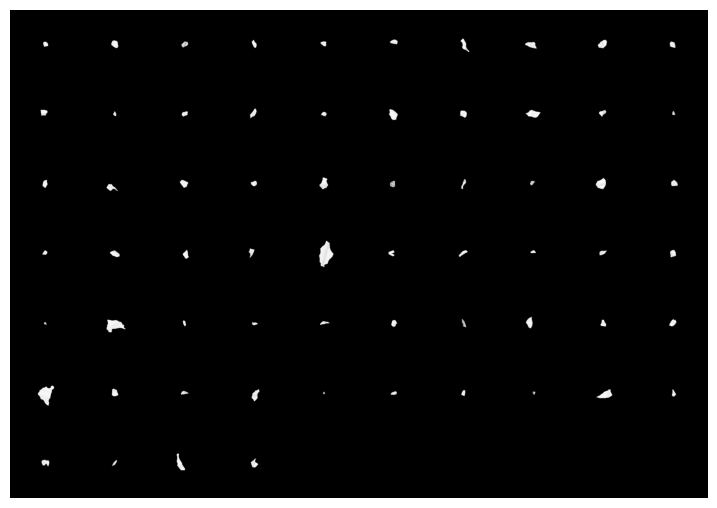

In [4]:
importlib.reload(utils)

dset, loader, dset_test, loader_test = run.get_datasets_from_config(config) # get datasets specified by config
fig, axs = utils.plot_sample_data(loader) # Loading Training Set Images as per the batch size 
fig

In [5]:
config.model.encoder.n_channels = dset[0][0].shape[0]  # image channels
model = run.build_model_from_config(config)

### Get pre-trained model weights

In [6]:
pretrained_model_path = os.path.join(model_path, "wandb/offline-run-20240807_165044-04hn41p7/files/model.pt")

In [7]:
model_checkpoint = torch.load(pretrained_model_path)
model.to(device).cpu().train() # if keys don't match, try many combinations of putting it on and off cuda
#model.to(device).train()
missing_keys, unexpected_keys = model.load_state_dict(model_checkpoint['model_state_dict'], strict=False)
assert all(['_basisexpansion' in k for k in missing_keys]) # checking that the only missing keys from the state_dict are this one type

In [8]:
from utils import eval_utils
importlib.reload(eval_utils)
model.eval().cpu() 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).cpu()
x, y = next(iter(loader)) # One Batch: Training Set
#x, y = next(iter(loader_test)) # One Batch: Test Set

print(f"x shape: {x.shape}, device: {x.device}")
print(f"y shape: {y.shape}, device: {y.device}")

x shape: torch.Size([64, 1, 256, 256]), device: cpu
y shape: torch.Size([64]), device: cpu


### Run on CPU & Visualize the reconstruction grids

In [9]:
try:
    reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x.cpu(), align=True, device='cpu')
except Exception as e:
    print(f"Error on CPU: {e}")

Combined tensor shape: torch.Size([96, 1, 256, 258])
Grid shape: torch.Size([3098, 2082, 3])


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/o2vae_test/lib/python3.9/site-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/o2vae_test/lib/python3.9/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


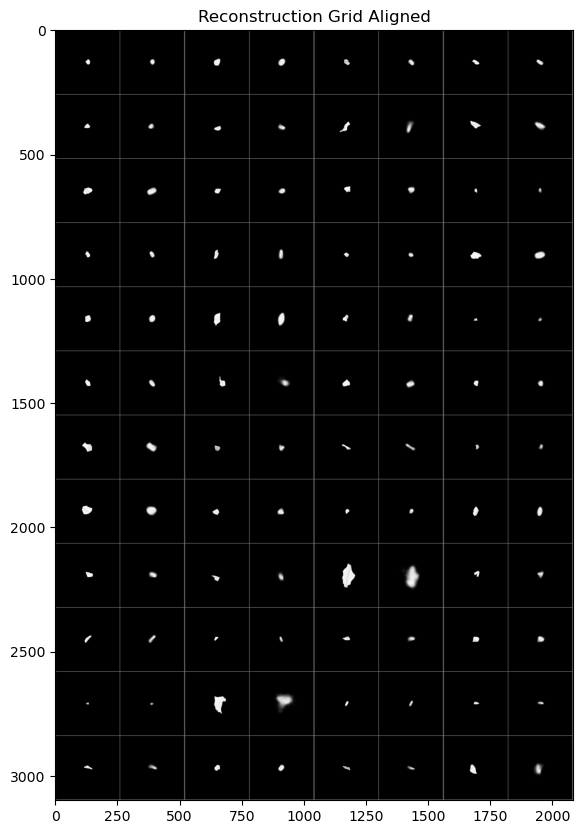

In [10]:
fig, axs = plt.subplots(figsize=(10, 10))
axs.imshow(reconstruct_grid_aligned.numpy(), cmap='gray')
axs.set_title('Reconstruction Grid Aligned')
plt.show()

Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])
Combined tensor shape: torch.Size([8, 1, 256, 258])
Grid shape: torch.Size([1034, 522, 3])


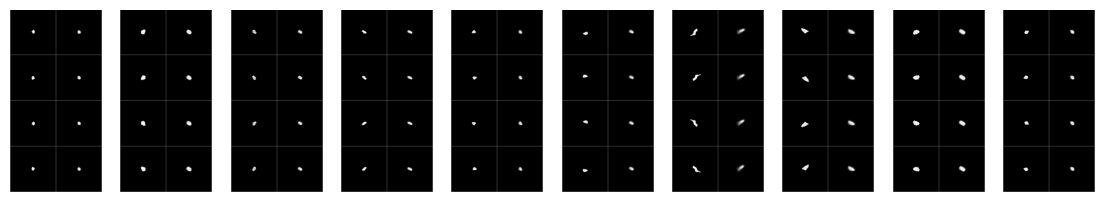

In [11]:
n_samples = 10
fig, axs = plt.subplots(1, n_samples, figsize = (14, 14))
for i in range(n_samples):
    xs = eval_utils.rotated_flipped_xs(x[[i]], 180)[:, 0]
    grid = eval_utils.reconstruction_grid(model, xs, align=False, ncol=2)
    axs[i].imshow(grid)
    axs[i].set_axis_off()

### Get Latent Dimension Embedding of Training & Test Sets 

In [ ]:
embeddings_train, labels_train = utils.get_model_embeddings_from_loader(model, 
                                                                        loader,
                                                                        return_labels=True) # Training Set

In [ ]:
embeddings_test, labels_test = utils.get_model_embeddings_from_loader(model, 
                                                                      loader_test,
                                                                      return_labels=True) # Test Set

### Save Latent Dimension Embeddings of the Training & Test Sets for Downstream Analysis

In [ ]:
# Clone Torch Tensors into numpy arrays
embed_train = embeddings_train.clone().numpy()
embed_test = embeddings_test.clone().numpy()
labels_train_ = labels_train.clone().numpy()
labels_test_ = labels_test.clone().numpy()

embedding_data = np.concatenate((embed_train, embed_test))
labels_data = np.concatenate((labels_train_, labels_test_)).astype(int)

ind_sort = np.argsort(labels_data)
labels_data = labels_data[ind_sort]
embedding_data = embedding_data[ind_sort]

np.savez('embeddings_data_A2_1.npz', embeddings=embedding_data, labels=labels_data)

In [ ]:
import umap
from utils import plotting_utils
reducer = umap.UMAP()

In [ ]:
transform = config.data.transform_train
data_x_tf = torch.stack([transform(img) for img in loader.dataset.tensors[0]])
umap_embedding = reducer.fit_transform(data_x_tf.view(data_x_tf.size(0), -1))

In [ ]:
grid, idxs = plotting_utils.get_embedding_space_embedded_images(umap_embedding,
                                                                data_x_tf, 
                                                                n_ximgs=30, 
                                                                n_yimgs=30)
fig, axs = plt.subplots(figsize = (12, 12))
axs.set_axis_off()
axs.set_title('UMAP embedding of training set')
axs.imshow(grid, cmap='gray')

In [ ]:
data_x_tf_test = torch.stack([transform(img) for img in loader_test.dataset.tensors[0]])
umap_embedding_test = reducer.fit_transform(data_x_tf_test.view(data_x_tf_test.size(0), -1))

In [ ]:
grid_test, idxs_test = plotting_utils.get_embedding_space_embedded_images(umap_embedding_test,
                                                                          data_x_tf_test, 
                                                                          n_ximgs=30, 
                                                                          n_yimgs=30)
fig, axs = plt.subplots(figsize = (12, 12))
axs.set_axis_off()
axs.set_title('UMAP embedding of test set')
axs.imshow(grid_test, cmap='gray')

In [ ]:
from utils import cluster_utils
importlib.reload(cluster_utils)

n_clusters=10

(labels_gmm, labels_kmeans), ((pca, cls_gmm), cls_kmeans), (centers_gmm, centers_kmeans), (scores_gmm, scores_kmeans)\
= cluster_utils.do_clusterering(embeddings_train, n_clusters=n_clusters)

In [ ]:
method = "kmeans" ## choose whether to use the 'gmm' or 'kmeans' clusters
if method=='gmm':
    labels, centers, scores = labels_gmm, centers_gmm, scores_gmm
elif method=='kmeans':
    labels, centers, scores = labels_kmeans, centers_kmeans, scores_kmeans
else:
    raise ValueError()

In [ ]:
### sample images from the cluster - 
# param `cluster_sampling_method`. 
# If `none` then random sample
# If `uniform` then using `score` (likelihood object is in its cluster), sample uniformly 
#      from high score (left) to low score (right)
# If `top` sample high `score`
# If `bottom` sample low `score`
# if `std`, then remove samples that have the lowest `score`, where the threshold is 
#  found by measuring std deviation of score, and thresholding with param stds_fit (default 1)

cluster_sampling_method='std'
n_examples=20 # n_examples: number of samples per cluster
grid, counts = cluster_utils.make_sample_grid_for_clustering(labels,
                                                             data_x_tf,
                                                             scores, 
                                                             n_examples=n_examples, 
                                                             stds_filt=1,
                                                             method=cluster_sampling_method,
                                                             paper_figure_grid=0, 
                                                             verbose=0)
fig, axs = plt.subplots(figsize=(10, 10))
axs.imshow(grid)
axs.set_axis_off();